#### PCA ( Analyse en Composantes Principale )
L'Analyse en Composantes Principales (PCA) est une technique de réduction de dimension utilisée pour explorer et visualiser des ensembles de données complexes. Elle consiste à projeter les données dans un nouvel espace de dimensions inférieures, tout en conservant autant que possible la variance des données d'origine

Nous avons effectuer une réduction de dimension sur les données normalisées dans le code principal. Nous indiquons à PCA de réduire la dimension à 100 composants principaux. Ensuite, PCA ajuste le modèle aux données normalisées et transforme ces données en utilisant les composants principaux calculés. Ce choix de 100 composants a été fait après plusieurs essais pour obtenir de bons scores des modèles testés par la suite.

Dans ce notebook, nous vous montrerons comment nous avons choisi la valeur optimale du nombre de composants en testant plusieurs possibilités sur plusieurs métriques (accuracy, précision, rappel, F1-score) pour un modèle de régression logistique. 

Il est important de noter que nous avons effectué les mêmes essais sur tous les autres modèles, mais leur entraînement prendrait beaucoup de temps si nous les incluions dans ce notebook.

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer,  WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
import numpy as np
from sklearn.metrics import *
from skimpy import skim
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metrics
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import warnings
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import seaborn as sns

Nous commençons par charger nos données à partir d'un fichier CSV.

In [2]:

df = pd.read_csv('../data/train.csv')
df

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


In [3]:
X = df["full_text"]
X

0        Many people have car where they live. The thin...
1        I am a scientist at NASA that is discussing th...
2        People always wish they had the same technolog...
3        We all heard about Venus, the planet without a...
4        Dear, State Senator\r\n\r\nThis is a letter to...
                               ...                        
17302    the story " The Challenge of Exploing Venus " ...
17303    Technology has changed a lot of ways that we l...
17304    If you don't like sitting around all day than ...
17305    In "The Challenge of Exporing Venus," the auth...
17306    Venus is worthy place to study but dangerous. ...
Name: full_text, Length: 17307, dtype: object

In [4]:
y = df["score"]
y

0        3
1        3
2        4
3        4
4        3
        ..
17302    2
17303    4
17304    2
17305    1
17306    2
Name: score, Length: 17307, dtype: int64

Nous procédons au prétraitement de nos données.

In [5]:
# Initialize the PorterStemmer
stemmer =  PorterStemmer()

def preprocess_text(text):
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Apply stemming to each word
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    
    # Join the stemmed words back into a sentence
    stemmed_text = " ".join(stemmed_words)
    
    return stemmed_text

X = X.apply(preprocess_text)
X

0        mani peopl car live . thing n't know use car a...
1        scientist nasa discuss `` face '' mar . explai...
2        peopl alway wish technolog seen movi , best ne...
3        heard venu , planet without almost oxygen eart...
4        dear , state senat letter argu favor keep elec...
                               ...                        
17302    stori `` challeng explo venu `` inform piec da...
17303    technolog chang lot way live today . nowaday p...
17304    n't like sit around day great opportun partici...
17305    `` challeng expor venu , '' author suggest stu...
17306    venu worthi place studi danger . reaosn thei c...
Name: full_text, Length: 17307, dtype: object

In [6]:
vectorizer = CountVectorizer(max_features=5000)
vectors = vectorizer.fit_transform(X).toarray()
vectors.shape

(17307, 5000)

In [7]:


scaler = StandardScaler()

vectors_modified = scaler.fit_transform(vectors)

vectors_modified

array([[-0.04428957,  3.35526711, -0.15647835, ..., -0.17205823,
        -0.05699234, -0.08668054],
       [-0.04428957, -0.16965749, -0.15647835, ..., -0.17205823,
        -0.05699234, -0.08668054],
       [-0.04428957, -0.16965749, -0.15647835, ..., -0.17205823,
        -0.05699234, -0.08668054],
       ...,
       [-0.04428957, -0.16965749, -0.15647835, ..., -0.17205823,
        -0.05699234, -0.08668054],
       [-0.04428957, -0.16965749, -0.15647835, ..., -0.17205823,
        -0.05699234, -0.08668054],
       [-0.04428957, -0.16965749, -0.15647835, ..., -0.17205823,
        -0.05699234, -0.08668054]])

Comme vous pouvez le remarquer ici, nous avons initialisé une liste avec différents nombres de composants pour déterminer la meilleure valeur parmi toutes afin de la sélectionner.

In [9]:
pca_n_components = [10,20,50,100,200,500,1000,3000]
X = []

for n_comp in pca_n_components:
    pca = PCA(n_components=n_comp)

    X_i = pca.fit_transform(vectors_modified)
    X.append(X_i)


In [12]:

accuracies = []
precisions = []
recalls = []
f1s =  []


for i,n_comp in enumerate(pca_n_components):
    X_train, X_test, y_train, y_test = train_test_split(X[i], y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Calculate precision
    precision = precision_score(y_test, y_pred, average='weighted')
    precisions.append(precision)

    # Calculate recall
    recall = recall_score(y_test, y_pred, average='weighted')
    recalls.append(recall)

    # Calculate F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1s.append(f1)

    print(accuracy)


0.5759676487579434
0.5834777585210861
0.5950317735413057
0.6048526863084922
0.6010976314269209
0.5869439630271519
0.5551704217215483
0.4809358752166378


Voici des graphiques qui résument l'évaluation des quatre métriques différentes (accuracy, précision, recall, f1-score) par rapport au nombre de composants PCA choisi.

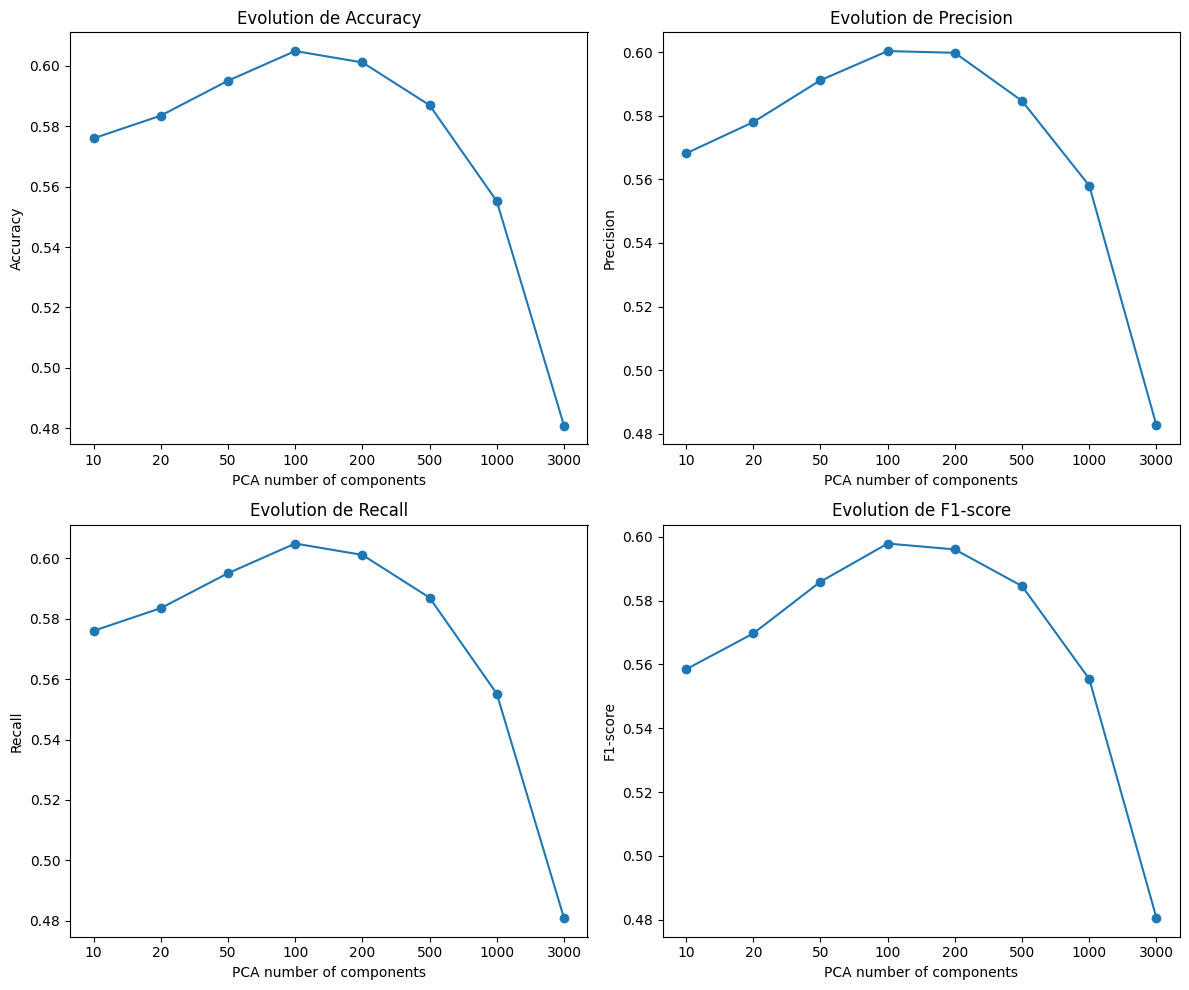

In [18]:
# Création des graphiques
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot( [str(x) for x in pca_n_components], accuracies, marker='o')
plt.title('Evolution de Accuracy')
plt.xlabel('PCA number of components')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot( [str(x) for x in pca_n_components], precisions, marker='o')
plt.title('Evolution de Precision')
plt.xlabel('PCA number of components')
plt.ylabel('Precision')

plt.subplot(2, 2, 3)
plt.plot( [str(x) for x in pca_n_components], recalls, marker='o')
plt.title('Evolution de Recall')
plt.xlabel('PCA number of components')
plt.ylabel('Recall')

plt.subplot(2, 2, 4)
plt.plot( [str(x) for x in pca_n_components], f1s, marker='o')
plt.title('Evolution de F1-score')
plt.xlabel('PCA number of components')
plt.ylabel('F1-score')

plt.tight_layout()
plt.show()


### Conclusion : 
Nous remarquons que pour toutes les métriques, nous avons un pic ou une valeur maximale avec le nombre de composants PCA à 100. On peut observer que les performances augmentent jusqu'à atteindre cette valeur, puis elles diminuent à nouveau avec des grandes valeurs de composants de PCA pour toutes les métriques avec un comportement similaire. Nous déduisons donc que la meilleure valeur à prendre pour réduire la dimension de nos entrées est 100. C'est d'ailleurs la valeur que nous avons utilisée dans notre code principal.